In [4]:
from langchain import OpenAI, PromptTemplate
from datetime import datetime, timedelta
import random
import matplotlib.pyplot as plt
import pandas as pd
import dspy
import numpy as np
import concurrent.futures
from dspy.evaluate.evaluate import Evaluate

#### Load Data

In [5]:
cases_data = pd.read_csv('/Users/shashankkumar/Documents/GitHub/MacroEcon/models/covid/data/county_data.csv')
cases_data = cases_data[cases_data['county'] == 'Kings County'].sort_values('date')
cases_data['date'] = pd.to_datetime(cases_data['date'])
cases_data['year'] = cases_data['date'].dt.year
cases_data['month'] = cases_data['date'].dt.month
monthly_cases = cases_data.groupby(['year', 'month'])['cases_week'].sum().reset_index()
monthly_cases['year'] = monthly_cases['year'].astype(int) - monthly_cases['year'].astype(int).min() +1 
monthly_cases
# cases_data

,year,month,cases_week
0,1,8,80.0
1,1,9,72.0
2,1,10,204.0
3,1,11,453.0
4,1,12,892.0
5,2,1,1702.0
6,2,2,883.0
7,2,3,874.0
8,2,4,701.0
9,2,5,205.0


In [11]:
def get_labor_data():
    labor_data = pd.read_csv('/Users/shashankkumar/Documents/GitHub/MacroEcon/simulator_data/NYC/Unemployment_unprocessed/unemployment_rate_csvs/Brooklyn-Table.csv')
    labor_data = labor_data.rename(columns={
    "Revised 2019-2023 Labor Force Data": "area",
    "Unnamed: 1": "year",
    "Unnamed: 2": "month",
    "Unnamed: 3": "labor_force",
    "Unnamed: 4": "employed",
    "Unnamed: 5": "unemployed",
    "Unnamed: 6": "unemployment_rate"
    })
    labor_data = labor_data.drop(labor_data.index[:2])
    labor_data = labor_data.dropna()
    labor_data.reset_index(drop=True, inplace=True)
    labor_data['labor_force'] = labor_data['labor_force'].str.replace('\t', '')
    labor_data['labor_force'] = labor_data['labor_force'].str.replace(',', '')
    labor_data['labor_force'] = labor_data['labor_force'].astype(int)
    month_to_index = {
    'Jan': 0, 'Feb': 1, 'Mar': 2, 'Apr': 3, 'May': 4, 'Jun': 5,
    'Jul': 6, 'Aug': 7, 'Sep': 8, 'Oct': 9, 'Nov': 10, 'Dec': 11,'Avg': 12
    }
    labor_data['month'] = labor_data['month'].map(month_to_index)
    labor_data['year'] = labor_data['year'].astype(int) - labor_data['year'].astype(int).min()
    labor_data['area'] = labor_data['area'].replace('Kings County', 1)
    labor_data.sort_values(by=['year', 'month'], inplace=True)
    return labor_data

labor_data = get_labor_data()
labor_data = labor_data[labor_data['year'] != 0]
merged_data = monthly_cases.merge(labor_data, on=['year', 'month'])
merged_data['labor_force_pct_change'] = merged_data['labor_force'].pct_change() * 100
merged_data


,year,month,cases_week,area,labor_force,employed,unemployed,unemployment_rate,labor_force_pct_change
0,1,8,80.0,1,1194700,"\t1,020,900","\t173,700",\t14.5,NaN
1,1,9,72.0,1,1203100,"\t1,044,100","\t159,000",\t13.2,0.703105
2,1,10,204.0,1,1197400,"\t1,046,500","\t150,900",\t12.6,-0.473776
3,1,11,453.0,1,1193100,"\t1,048,100","\t145,000",\t12.2,-0.359111
4,1,12,892.0,1,1202983,"\t1,053,542","\t149,425",\t12.6,0.828346
5,2,1,1702.0,1,1208100,"\t1,055,100","\t152,900",\t12.7,0.425359
6,2,2,883.0,1,1212600,"\t1,070,900","\t141,700",\t11.7,0.372486
7,2,3,874.0,1,1207900,"\t1,072,600","\t135,300",\t11.2,-0.387597
8,2,4,701.0,1,1194700,"\t1,069,800","\t124,900",\t10.5,-1.092806
9,2,5,205.0,1,1211100,"\t1,077,700","\t133,400",\t11.0,1.372730


In [12]:
correlation = merged_data['cases_week'].corr(merged_data['labor_force_pct_change'])
correlation

0.23769907497398335

In [13]:
input_data = merged_data[['cases_week', 'labor_force_pct_change']]
# input_data.dropna(inplace=True)
input_data = input_data.reset_index()
input_data

,index,cases_week,labor_force_pct_change
0,0,80.0,NaN
1,1,72.0,0.703105
2,2,204.0,-0.473776
3,3,453.0,-0.359111
4,4,892.0,0.828346
5,5,1702.0,0.425359
6,6,883.0,0.372486
7,7,874.0,-0.387597
8,8,701.0,-1.092806
9,9,205.0,1.372730


#### Hypothesis Testing using Dspy

In [35]:
turbo = dspy.OpenAI(model='gpt-3.5-turbo', api_key=OPENAI_API_KEY,temperature=0.0)
colbertv2_wiki17_abstracts = dspy.ColBERTv2(url='http://20.102.90.50:2017/wiki17_abstracts')
dspy.settings.configure(lm=turbo)

In [36]:
class BasicQA(dspy.Signature):
    """
    You are an individual living in New York City (NYC) during the COVID-19 pandemic. You need to decide your willingness to work each month based on the current situation of the number of COVID cases in NYC.
    """
    # context = dspy.InputField(desc="may contain relevant facts")
    question = dspy.InputField(desc="will contain the number of COVID cases in NYC and your age, to help you decide your willingness to work. ")
    # answer = dspy.OutputField(desc="often between 1 and 5 words representing realistic probability between 0 and 1 representing the fraction of your monthly income you would want to spend this month")
    answer = dspy.OutputField(desc="an int value between 0 and 1 representing realistic probability of your willingness to work")

class COT(dspy.Module):
    def __init__(self, num_passages=3):
        super().__init__()

        # self.retrieve = dspy.Retrieve(k=num_passages)
        self.generate_answer = dspy.ChainOfThought(BasicQA)
    
    def forward(self, question):
        # context = self.retrieve(question).passages
        prediction = self.generate_answer(question=question)
        return dspy.Prediction(answer=prediction)

def dspy_predict(num_cases,age,predictor):
    query = f"Current number of COVID cases in NYC: {num_cases},your age: {age}, stimulus check: $1200"
    pred = predictor(question=query)
    return pred.answer

In [31]:
pred = dspy_predict(50000,30,COT())
pred

Prediction(
    rationale='determine the willingness to work. With 50,000 COVID cases in NYC, the risk of exposure is still relatively high. At 30 years old, I am at a lower risk compared to older individuals, but the virus can still have serious consequences. Additionally, with a stimulus check of $1200, I may have some financial support to rely on. Considering these factors, it may be safer to prioritize health and safety over work at this time.',
    answer='0.3'
)

In [8]:
def predict(num_cases,age, predictor):
    # age = random.randint(18, 65)
    try:
        prediction = dspy_predict(num_cases, age, predictor)
        return prediction
    except Exception as e:
        pass

In [ ]:
ages = [random.randint(18, 65) for i in range(30)]
ages

In [37]:
def run_queries(num_agent,input_data,ages,predictor):
    predicted_labor_force_data = pd.DataFrame(columns=[ 'index', 'labor_force'])
    for index,num_cases in enumerate(input_data['cases_week']):
        prediction_for_month = []
        print(num_cases)
        with concurrent.futures.ThreadPoolExecutor() as executor:
            futures = [executor.submit(predict,num_cases, age,predictor) for age in ages]
            prediction_for_month = [f.result() for f in futures if f.result() is not None]
            # print(prediction_for_month)
            prediction_for_month = [bernoulli.rvs(float(prediction.answer.strip()[:3])) for prediction in prediction_for_month]
        labor_force_for_month = sum(prediction_for_month)
        print(labor_force_for_month)
        pred = pd.DataFrame([[labor_force_for_month,index]], columns=['labor_force','index'])
        predicted_labor_force_data = pd.concat([predicted_labor_force_data,pred])
    return predicted_labor_force_data

num_agent = 20
ages = [random.randint(18, 65) for i in range(num_agent)]
predicted_labor_force_data = run_queries(num_agent,input_data,ages,COT())
predicted_labor_force_data['labor_force_pct_change'] = predicted_labor_force_data['labor_force'].pct_change() * 100
predicted_merged_data = predicted_labor_force_data.merge(input_data, on=['index'])
predicted_merged_data.dropna(inplace=True)

80.0
15
72.0
11
204.0
15
453.0
13
892.0
13
1702.0
11
883.0
13
874.0
7
701.0
8
205.0
13
33.0
12
184.0
16
413.0
11
397.0
9
286.0
10
364.0
10
2262.0
7
6222.0
9
326.0
14
165.0
13
709.0
10
1153.0
7
814.0
10
1205.0
13
580.0
14
442.0
13
388.0
14


In [24]:
predicted_labor_force_data_with_stimulus = predicted_labor_force_data

In [33]:
predicted_merged_data

,index,labor_force,labor_force_pct_change_x,cases_week,labor_force_pct_change_y
1,1,16,14.285714,72.0,0.703105
2,2,12,-25.000000,204.0,-0.473776
3,3,16,33.333333,453.0,-0.359111
4,4,14,-12.500000,892.0,0.828346
5,5,15,7.142857,1702.0,0.425359
6,6,12,-20.000000,883.0,0.372486
7,7,12,0.000000,874.0,-0.387597
8,8,9,-25.000000,701.0,-1.092806
9,9,12,33.333333,205.0,1.372730
10,10,17,41.666667,33.0,0.734869


In [27]:
predicted_merged_data['cases_week'].corr(predicted_merged_data['labor_force_pct_change_x'])

-0.10781880096663427

In [28]:
predicted_merged_data_with_stimulus = predicted_labor_force_data_with_stimulus.merge(input_data, on=['index'])
predicted_merged_data_with_stimulus['cases_week'].corr(predicted_merged_data_with_stimulus['labor_force_pct_change_x'])

-0.347309292443175

In [34]:
predicted_merged_data['cases_week'].corr(predicted_merged_data['labor_force_pct_change_x'])

-0.24002688911549

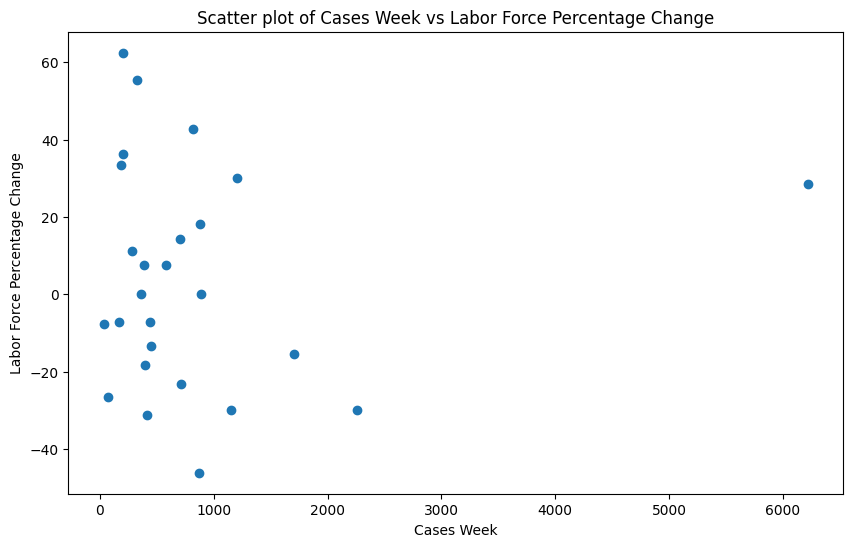

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(predicted_merged_data['cases_week'], predicted_merged_data['labor_force_pct_change_x'])
plt.xlabel('Cases Week')
plt.ylabel('Labor Force Percentage Change')
plt.title('Scatter plot of Cases Week vs Labor Force Percentage Change')
plt.show()

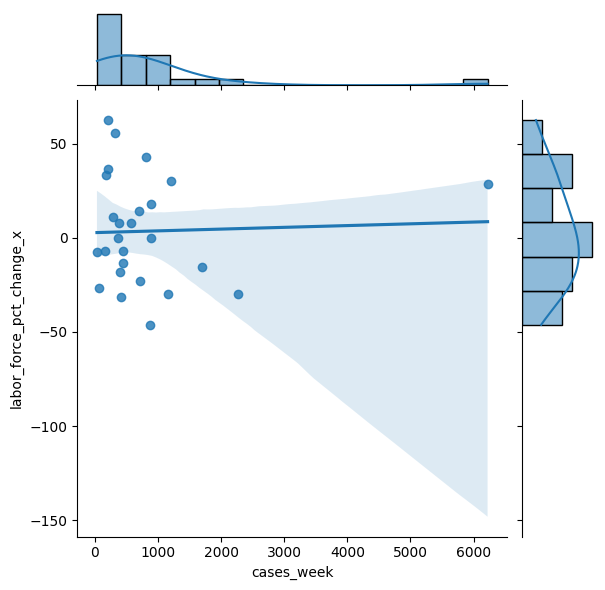

In [39]:
import seaborn as sns

sns.jointplot(x='cases_week', y='labor_force_pct_change_x', data=predicted_merged_data, kind='reg')
plt.show()

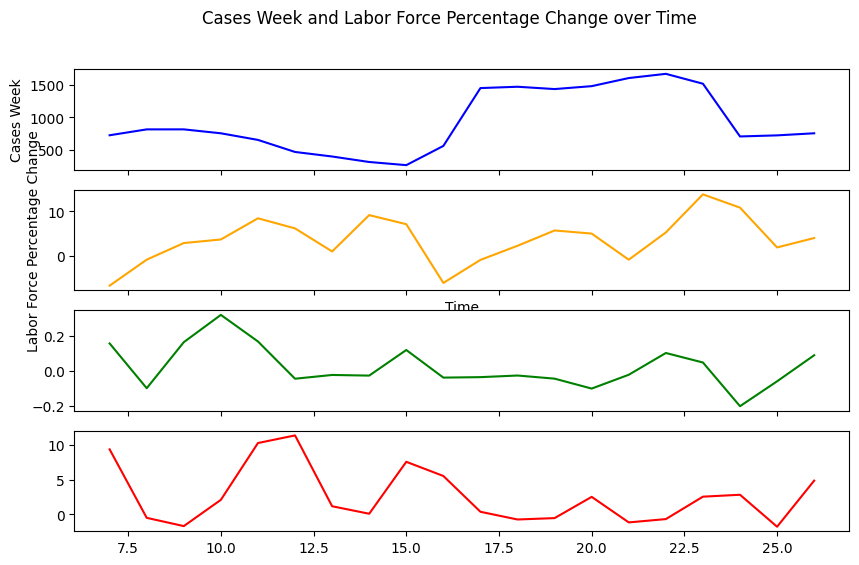

In [51]:
import matplotlib.pyplot as plt

# Define the window size for the rolling mean
window_size = 7

fig, axs = plt.subplots(4, sharex=True, figsize=(10, 6))

axs[0].plot(predicted_merged_data['cases_week'].rolling(window_size).mean(), label='Cases Week', color='blue')
axs[1].plot(predicted_merged_data['labor_force_pct_change_x'].rolling(window_size).mean(), label='Labor Force Percentage Change', color='orange')
axs[2].plot(predicted_merged_data['labor_force_pct_change_y'].rolling(window_size).mean(), label='Labor Force Percentage Change Real World', color='green')
axs[3].plot(predicted_merged_data_with_stimulus['labor_force_pct_change_x'].rolling(window_size).mean(), label='Labor Force Percentage Change With Stimulus', color='red')

axs[0].set(ylabel='Cases Week')
axs[1].set(xlabel='Time', ylabel='Labor Force Percentage Change')

plt.suptitle('Cases Week and Labor Force Percentage Change over Time')
plt.show()

#### Setup Testing and Training Data

In [107]:
query_list = []
for cases,labor_force_pct in zip(input_data['cases_week'],input_data['labor_force_pct_change']):
    query = f"Current number of COVID cases in NYC: {cases}"
    query_list.append((query,labor_force_pct))
query_list
train_list = [query_list[1:23]]
val_list = [query_list[23:]]
trainset = [dspy.Example(question=question, answer=str(answer)).with_inputs('question') for question, answer in train_list[0]]
valset = [dspy.Example(question=question, answer=str(answer)).with_inputs('question') for question, answer in val_list[0]]

In [108]:
from dspy.teleprompt import BootstrapFewShot

# Validation logic: check that the predicted answer is correct.
def validate_context_and_answer(example, pred, trace=None):
    answer_EM = dspy.evaluate.answer_exact_match(example, pred)
    answer_PM = dspy.evaluate.answer_passage_match(example, pred)
    return answer_EM and answer_PM

def validate_answer(example, pred, trace=None):
    answer_EM = dspy.evaluate.answer_exact_match(example, pred)
    # answer_PM = dspy.evaluate.answer_passage_match(example, pred)
    return answer_EM
# Set up a basic teleprompter, which will compile our RAG program.
teleprompter = BootstrapFewShot(metric=validate_answer)

# Compile!
compiled_cot = teleprompter.compile(COT(), trainset=trainset)

100%|██████████| 22/22 [00:48<00:00,  2.22s/it]

Bootstrapped 0 full traces after 22 examples in round 0.


In [99]:
evaluate_compiled_module = Evaluate(devset=valset, num_threads=8, display_progress=True,display_table=7)
# Evaluate the `compiled_rag` program with the `answer_exact_match` metric.
metric = dspy.evaluate.answer_exact_match
evaluate_compiled_module(compiled_cot, metric=metric)

Average Metric: 3 / 7  (42.9): 100%|██████████| 7/7 [00:04<00:00,  1.61it/s]

Average Metric: 3 / 7  (42.9%)


,question,example_answer,pred_answer,answer_exact_match
0,Current number of COVID cases in NYC: 709.0,0.12496875781053962,0.12496875781053962,✔️ [True]
1,Current number of COVID cases in NYC: 1153.0,0.14145448493925183,0.14145448493925183,✔️ [True]
2,Current number of COVID cases in NYC: 814.0,0.8059825508932361,0.8059825508932361,✔️ [True]
3,Current number of COVID cases in NYC: 1205.0,-0.11539729640619445,0.2156789345678901,False
4,Current number of COVID cases in NYC: 580.0,-0.9985146063706929,0.4567890123456789,False
5,Current number of COVID cases in NYC: 442.0,0.8252063015753874,0.4567890123456789,False
6,Current number of COVID cases in NYC: 388.0,-0.14880952380952328,0.4567890123456789,False


42.86

In [100]:
predicted_labor_force_data = run_queries(10,input_data,compiled_cot)
predicted_labor_force_data['labor_force_pct_change'] = predicted_labor_force_data['labor_force'].pct_change() * 100
predicted_merged_data = predicted_labor_force_data.merge(input_data, on=['index'])
predicted_merged_data.dropna(inplace=True)
correlation = predicted_merged_data['cases_week'].corr(predicted_merged_data['labor_force_pct_change_x'])
correlation

80.0
72.0
204.0
453.0
892.0
1702.0
883.0
874.0
701.0
205.0
33.0
184.0
413.0
397.0
286.0
364.0
2262.0
6222.0
326.0
165.0
709.0
1153.0
814.0
1205.0
580.0
442.0
388.0


/Users/shashankkumar/anaconda3/envs/LIDA/lib/python3.10/site-packages/numpy/lib/function_base.py:2742: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


nan

In [82]:
turbo.inspect_history(n=7)





You are an individual living in New York City (NYC) during the COVID-19 pandemic. You need to decide your willingness to work each month based on the current situation of the number of COVID cases in NYC.

---

Follow the following format.

Question: will contain the number of COVID cases in NYC and your age, to help you decide your willingness to work.
Reasoning: Let's think step by step in order to ${produce the answer}. We ...
Answer: an int value between 0 and 1 representing realistic probability of your willingness to work

---

Question: Current number of COVID cases in NYC: 883.0,your age: 26
Reasoning: Let's think step by step in order to Answer: 0.8
Answer: 0.8







You are an individual living in New York City (NYC) during the COVID-19 pandemic. You need to decide your willingness to work each month based on the current situation of the number of COVID cases in NYC.

---

Follow the following format.

Question: will contain the number of COVID cases in NYC and your age,

In [84]:
import json


json.loads('{\n  "work": 0.8,\n  "consumption": 0.7\n}')

{'work': 0.8, 'consumption': 0.7}